# Computing statistics from trajectories

In [58]:
#!/usr/bin/env python
# coding: utf-8

import contracts
contracts.disable_all()

import geometry as geo
import math 
import numpy as np
from os import path, listdir
from scipy import stats
import yaml
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from math import ceil

import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_svg, ipython_draw_html
from duckietown_world.world_duckietown.tile import get_lane_poses
from duckietown_world import draw_static


# import geometry_msgs
# import geometry_msgs.msg
# import geometry_msgs.msg._TransformStamped
# import geometry_msgs.msg._TransformStamped as TransformStamped

## Goal of the notebook

Familiarize yourself with duckietown world, with an example. The goal is to plot the average trajectory along with its standard deviation for a set of experiments done on fixed map and starting conditions. 

Let's start with visualizing the map.

In [2]:
from os import path, listdir
import json
import yaml
import matplotlib.pyplot as plt
import numpy as np
# from scipy import interpolate

experiment_dir = ''

logs_path = path.join(experiment_dir, '../data/BenchmarkXY')

In [12]:

logs_path = path.join(experiment_dir, '../data/BenchmarkXY/benchmarks/same_bm')

localization_logs = [path.join(logs_path, f) for f in listdir(logs_path) if path.isfile(path.join(logs_path, f))]
print(f'Logs found: {localization_logs}')

nb_bm_found = len(localization_logs)
all_logs = []
names=[]
compare_a = []
compare_b = []
i = 0
for filename in localization_logs:
    with open(filename, 'r') as file:
        current = []
        names.append(path.basename(filename))
        current.append(yaml.safe_load(file))
        
    all_logs.append(current)
#         if i == 0:
#             name_a = filename
#             compare_a.append(yaml.safe_load(file))
#         if i == 1:
#             name_b = filename
#             compare_b.append(yaml.safe_load(file))
    i += 1
# all_logs_np = np.asarray(all_logs)
# print(np.split(all_logs_np, nb_bm_found))


Logs found: ['../data/BenchmarkXY/benchmarks/same_bm/benchmark_results_1_a.yaml', '../data/BenchmarkXY/benchmarks/same_bm/benchmark_results_1_d.yaml', '../data/BenchmarkXY/benchmarks/same_bm/benchmark_results_1_b.yaml', '../data/BenchmarkXY/benchmarks/same_bm/benchmark_results_1_c.yaml']


In [14]:
print(all_logs[0])

[{'Benchmark_Type': 'Lane Following', 'Results': {'Number_of_completed_laps': 1, 'Number_of_tiles_covered': 9, 'Avg_time_needed_per_tile': 4.5, 'Time_needed_per_straight_tile_sec': 'ToDo', 'Time_needed_per_curved_tile': 'ToDo', 'Theoretical_length_of_benchmark': 50.0, 'Length_of_recorded_bag': 50.2666, 'Actual_length_of_benchmark': 35.0, 'Tolerance_out_of_sight': 3.0, 'Out_of_sight': False, 'Time_out_of_sight': 50.2666, 'Tolerance_too_slow_sec': 30.0, 'Too_slow': True, 'Time_too_slow': 35.0, 'Position_too_slow': 'ToDo', 'Ground_truth_wt_std_offset': 0.00045, 'Ground_truth_wt_std_angle': 0.23183945611331125, 'Ground_truth_wt_mean_offset': -1.204620209821937e-19, 'Ground_truth_wt_mean_angle': 0.14495991919092255, 'Measurements_db_std_offset': 1.4613994818166e-05, 'Measurements_db_std_angle': 0.00156806339405238, 'Measurements_db_mean_offset': 0.11098853490421456, 'Measurements_db_mean_angle': 0.13755042879886714, 'std_diff_btw_estimation_and_ground_truth_offset': 0.04971650907604792, 'st

In [41]:
no_meaningful_comp = ['Tolerance_out_of_sight', 'Tolerance_too_slow_sec', 'Theoretical_length_of_benchmark']
no_meaningful_rel_comp = ['Out_of_sight', 'Too_slow']
list_of_comp_todo = ['Position_too_slow', 'Time_needed_per_straight_tile_sec', 'Time_needed_per_curved_tile']

nb_of_properties = len(all_logs[0][0]['Results'])

def Average(lst): 
    lst_abs = [abs(x) for x in lst]
    return sum(lst_abs) / len(lst) 

In [52]:
for i in range(0, nb_bm_found):
    if all_logs[0][0]['Benchmark_Type'] != all_logs[i][0]['Benchmark_Type']:
        print("This avg calculation work as the results come from two different Benchmarks")

In [114]:
benchmark_std = path.join(experiment_dir, 'out/benchmark_std.yaml')
benchmark_mean = path.join(experiment_dir, 'out/benchmark_mean.yaml')
benchmark_std_graph = path.join(experiment_dir, 'out/benchmark_std_graph.jpg')
benchmark_boxplot_graph = path.join(experiment_dir, 'out/benchmark_boxplot_graph.jpg')

In [71]:
def get_unit(info):
    if info == 'Number_of_completed_laps':
        unit = 'laps'
    elif info == 'Number_of_tiles_covered':
        unit = 'tiles'
    elif info == 'Avg_time_needed_per_tile':
        unit = 'seconds per tile'
    elif info == 'Time_needed_per_straight_tile_sec':
        unit = 'seconds per tile'
    elif info == 'Time_needed_per_curved_tile':
        unit = 'seconds per tile'
#         elif info == 'Theoretical_length_of_benchmark':
#             unit = 'seconds'
    elif info == 'Length_of_recorded_bag':
        unit = 'seconds' 
    elif info == 'Actual_length_of_benchmark':
        unit = 'seconds'   
    elif info == 'Out_of_sight':
        unit = ' '  
    elif info == 'Time_out_of_sight':
        unit = 'seconds' 
    elif info == 'Too_slow':
        unit = ' '  
    elif info == 'Time_too_slow':
        unit = 'seconds' 
    elif info == 'Position_too_slow':
        unit = ' '
    elif info == 'Ground_truth_wt_std_offset':
        unit = 'meters' 
    elif info == 'Ground_truth_wt_std_angle':
        unit = 'radians' 
    elif info == 'Ground_truth_wt_mean_offset':
        unit = 'meters' 
    elif info == 'Ground_truth_wt_mean_angle':
        unit = 'radians' 
    elif info == 'Measurements_db_std_offset':
        unit = 'meters'
    elif info == 'Measurements_db_std_angle':
        unit = 'radians' 
    elif info == 'Measurements_db_mean_offset':
        unit = 'meters' 
    elif info == 'Measurements_db_mean_angle':
        unit = 'radians' 
    elif info == 'std_diff_btw_estimation_and_ground_truth_offset':
        unit = 'meters' 
    elif info == 'std_diff_btw_estimation_and_ground_truth_angle':
        unit = 'radians'
    elif info == 'mean_diff_btw_estimation_and_ground_truth_offset':
        unit = 'meters' 
    elif info == 'mean_diff_btw_estimation_and_ground_truth_angle':
        unit = 'radians'
    else:
        unit = 'Uuuups' 
    
    return unit

/home/linuslingg/duckietown-world/duckietown-world-venv/lib/python3.6/site-packages/ipykernel_launcher.py:99: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/home/linuslingg/duckietown-world/duckietown-world-venv/lib/python3.6/site-packages/ipykernel_launcher.py:103: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


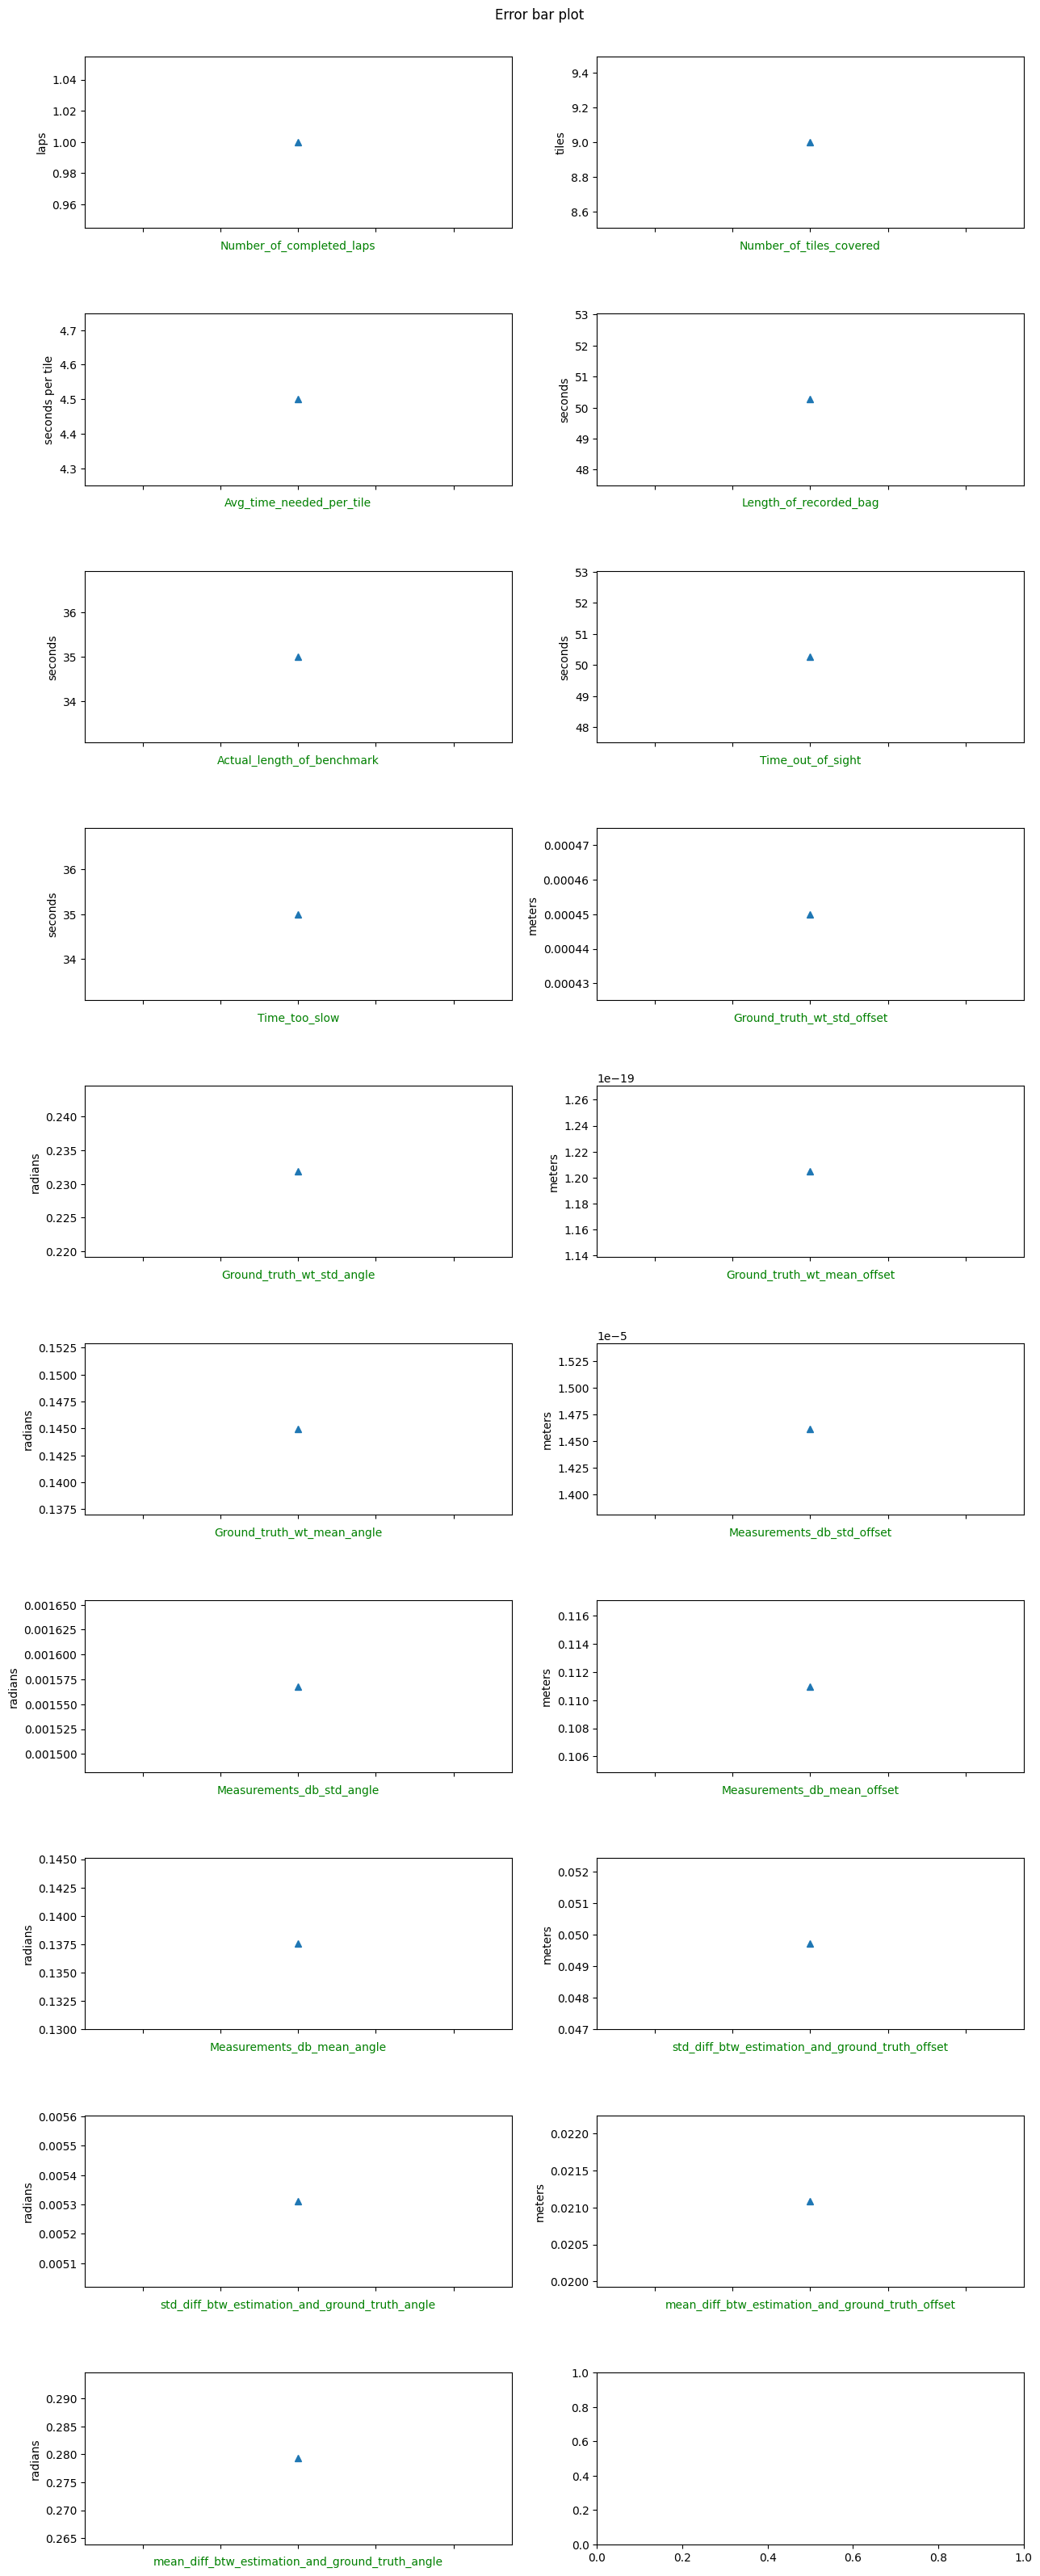

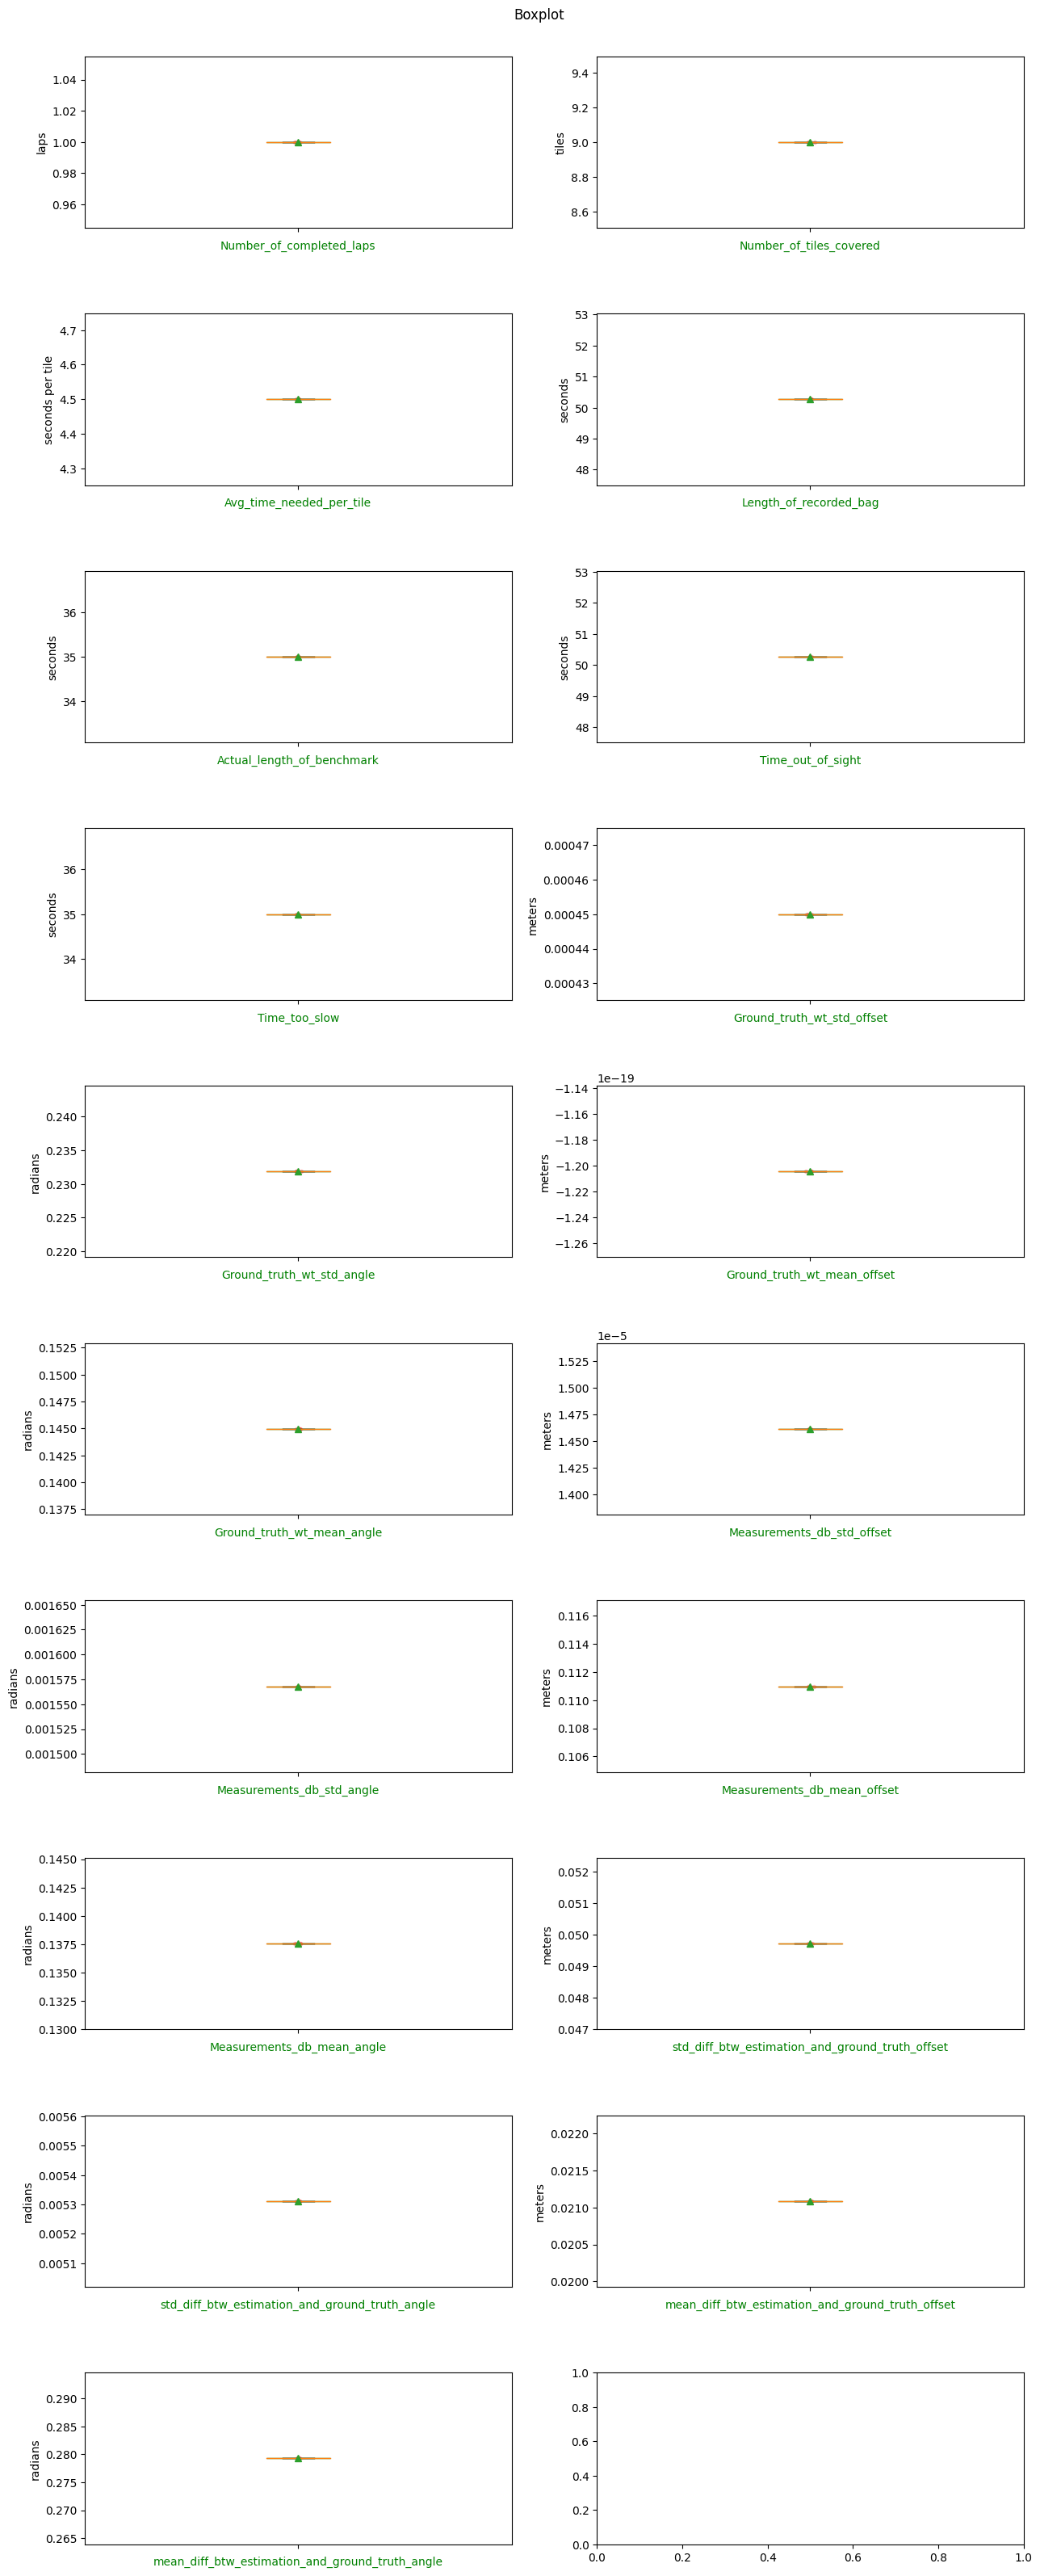

In [136]:
# Plots mean and Standard Deviation

import statistics
mean_bm = {'Benchmark_Type': all_logs[0][0]['Benchmark_Type']}
std_bm = {'Benchmark_Type': all_logs[0][0]['Benchmark_Type']}
all_results_mean = {}
all_results_std = {}

fig1, axes1 = plt.subplots(nrows=ceil((nb_of_properties-len(no_meaningful_comp)-len(list_of_comp_todo)-\
                                    len(no_meaningful_rel_comp))/2), ncols=2)
fig2, axes2 = plt.subplots(nrows=ceil((nb_of_properties-len(no_meaningful_comp)-len(list_of_comp_todo)-\
                                    len(no_meaningful_rel_comp))/2), ncols=2)
fig1.subplots_adjust(hspace=0.5)
fig1.suptitle('Error bar plot', y=.895)
fig2.subplots_adjust(hspace=0.5)
fig2.suptitle('Boxplot', y=.895)

count = 0

for i, prop in enumerate(all_logs[0][0]['Results']):
    results = []
    std_exist = False
    if prop not in list_of_comp_todo and (prop not in no_meaningful_comp):
        for j in range(0, nb_bm_found):
            results.append(all_logs[j][0]['Results'][prop])
           
        if type(results[0]) != bool:
            avg_result = Average(results)
            median_result = statistics.median(results)
            std_result = statistics.stdev(results)
            
            unit = get_unit(prop)
            # coefficient of variation calculation:
            # if lower than 1, the std can be considered small enough and one can stop running tests
            # https://www.researchgate.net/post/What_do_you_consider_a_good_standard_deviation
            cv = std_result/avg_result
            cv_median = std_result/median_result
            std_exist = True
#             print(cv)
            
        else:
            std_result = 'Not applicable'
            avg_result = results[0]
    else:
        std_result = 'ToDo'
        avg_result = 'ToDo'
    if std_exist:
        if cv >= 1.0:
            color = 'red'
            answer = 'no'
        elif cv < 1.0:
            color = 'green'
            answer = 'yes'
        else:
            color = 'black'
            answer = 'Sth went wrong'
        all_results_std.update({prop: {'Std': std_result, 'Mean': avg_result, \
                                'coefficient of variation calculation': cv, \
                                'Enough tests run for meaningful BM analyzis': answer}})
        # Figure 1: Mean and Std
        ax1 = axes1.flatten()[count]
        ax1.set_ylabel(unit)
        ax1.set_xlabel(prop)
        ax1.set_xticklabels([])
        ax1.errorbar(1, avg_result, yerr=std_result, linestyle='None', marker='^', ecolor = color)
        ax1.xaxis.label.set_color(color)
        # Figure 2: Boxplot:
        ax2 = axes2.flatten()[count]
        ax2.set_ylabel(unit)
        ax2.set_xlabel(prop)
        test = [1.0,2.0,3.0,4.0]
        ax2.boxplot(results, showmeans = True, notch=False, patch_artist=True,boxprops=dict(color=color))
        ax2.set_xticklabels([])
        ax2.xaxis.label.set_color(color)
        
        y = results
        x = np.random.normal(1, 0.004, size=len(y))
        ax2.plot(x, y, 'r.', alpha=0.2)
        
        count += 1
#         plt.show()
        
    else:
        all_results_std.update({'Std of ' + prop: std_result})
    all_results_mean.update({prop: avg_result})
    
std_bm.update( {"Results" : all_results_std} )
mean_bm.update( {"Results" : all_results_mean} )

fig1.set_figheight(40)
fig1.set_figwidth(15)
fig2.set_figheight(40)
fig2.set_figwidth(15)


fig1.savefig(benchmark_std_graph, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
fig2.savefig(benchmark_boxplot_graph, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
# print(std_bm)

with open(benchmark_std, 'w') as yaml_file:
    yaml.dump(std_bm, yaml_file, default_flow_style=False)
    
with open(benchmark_mean, 'w') as yaml_file:
    yaml.dump(mean_bm, yaml_file, default_flow_style=False)

In [286]:
# Backup Mean Calculation

# mean_bm = {'Benchmark_Type': all_logs[0][0]['Benchmark_Type']}
# all_results = {}
# for i, prop in enumerate(all_logs[0][0]['Results']):
#     results = []
#     if prop not in list_of_comp_todo:
#         for j in range(0, nb_bm_found):
#             results.append(all_logs[j][0]['Results'][prop])
        
#         if type(results[0]) != bool:
#             avg_result = Average(results)
#         else:
#             avg_result = results[0]
#     else:
#         avg_result = 'ToDo'
#     all_results.update({prop: avg_result})
    
# mean_bm.update( {"Results" : all_results} )

# benchmark_mean = path.join(experiment_dir, 'out/benchmark_mean.yaml')

# with open(benchmark_mean, 'w') as yaml_file:
#     yaml.dump(mean_bm, yaml_file, default_flow_style=False)


## Some utilities that we are going to use later